In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks")
from scipy import stats

## Теоретическая справка

### Критерий хи-квадрат

Используется для проверки гипотезы о независимости случайных величин. Рассмотрим основную (СВ независимы) и альтернативную (СВ зависимы) гипотезы следующих видов:

$$H_0: F_W(x, y) = F_X(x)F_Y(y) \forall x,y \in \rm I\!R$$

$$H_1: \exists x, y \in \rm I\!R: F_W(x,y)\neq F_X(x)F_Y(y)$$

#### Случай 1

$W = (X, Y)^T$ - дискретный вектор, то есть СВ $X$ принимает конечное число значений $\{a_1, a_2,\ldots, a_m\}$, а СВ $Y$ - $\{b_1, b_2,\ldots, b_k\}$

Введем обозначение $n_{ij}$ - число пар $(x, y) \in W_n = [(x_1, y_1), \ldots, (x_n, y_n)]^T$ таких, что $x = a_i, y = b_j$

$n_i = \sum\limits_{j=1}^k n_{ij}$ - число пар, где $x = a_i$, $i=\overline{1,m}$

$n_j = \sum\limits_{i=1}^m n_{ij}$ - число пар, где $y = b_j$, $j=\overline{1,k}$

$\sum\limits_{i=1}^m \sum\limits_{j=1}^k n_{ij} = n$, где $n$ - объем выборки

$p_{ij} = \frac{n_{ij}}{n}$, - вероятность встретить пару $(a_i, b_j)$

$p_{i} = \frac{n_i}{n}$, - вероятность встретить пару с $x = a_i$

$p_{j} = \frac{n_j}{n}$ - вероятность встретить пару с $y = b_j$

#### Случай 2

Если $W = (X, Y)^T$ - недискретный вектор (непрерывный), то надо сгруппировать данные (по бинам). Количество бинов выбирается произвольно. Лучше всего использовать правило Стёрджеса, то есть выбирать количество бинов ${\displaystyle q=1+\lfloor \log _{2}n\rfloor  =1+\lfloor 3.322\lg N\rfloor }$. Или более простое правило: $q \sim \sqrt n$

Тогда разбиваем область значений $X$ на $m > 1$ непересекающихся интервалов $$\{\Delta_{X, i}     \}:\bigcup\limits_{i=1}^m \Delta_{X, i} = V_X$$

Аналогично для $Y$ на $k>1$ непересекающихся интервалов ($V_Y$ - область значений СВ $Y$):

$$\{\Delta_{Y, j}     \}:\bigcup\limits_{j=1}^k \Delta_{Y, j} = V_Y$$

Тогда $n_{ij}$ - число пар $(x, y)$, таких что $x \in \Delta_{X, i}, y \in \Delta_{Y, j}$

$n_i$ - число пар, таких что $x \in \Delta_{X, i}, y$ - любой

$n_j$ - число пар, таких что $y \in \Delta_{Y, j}, x$ - любой

### Статистика

$$\tilde{\chi}^2 = T(W_n) = n \sum\limits_{i=1}^m \sum\limits_{j=1}^k \frac{(p_{ij} - p_i p_j)^2}{p_i p_j} = n \sum\limits_{i=1}^m \sum\limits_{j=1}^k \frac{(n_{ij} - \frac{n_i n_j}{n})^2}{n_i n_j}$$

Данная статистика имеет распределение хи-квадрат $\mathcal{H}_r$ с $r = (m-1)(k-1)$ степенями свободы, т.е. $\tilde{\chi}^2 \sim \mathcal{H}_r$

#### Критическая область

Пусть задан уровень значимости $\alpha$, тогда для даннного критерия критическая область имеет следующий вид:
$$
(\kappa_{1-\alpha}(r), +\infty)
$$

где $\kappa_{1-\alpha}(r)$ - квантиль уровня $1-\alpha$ распределения $\mathcal{H}_r$

#### Удобная формула для вычисления статистики

$$\tilde{\chi}^2 = n \left(\sum\limits_{i=1}^m \sum\limits_{j=1}^k \frac{(n_{ij})^2}{n_i n_j} - 1                 \right)$$

### Немного про меры связи

#### Мера связи Пирсона

$$P = \sqrt{\frac{\tilde{\chi}^2}{\tilde{\chi}^2 + n}}$$

называется коэффициентом взаимной сопряженности (или коэффициентом Пирсона)

при возрастании $m$ и $k$ стремится к коэффициенту корреляции:

$$P^2 = \frac{\tilde{\chi}^2}{\tilde{\chi}^2 + n} \rightarrow r_{XY}^2$$

Недостаток: максимальное значение $P$ равно $\sqrt{\frac{l-1}{l}} < 1$, где $l=\min(m,k)$

Поэтому Крамер ввел другую меру

#### Мера Крамера

$$C = \sqrt{\frac{\tilde{\chi}^2}{n\times \min(m-1, k-1)}}$$

называется коэффициентом Крамера. Значение лежит в отрезке $[0;1]$, максимум достигается тогда и только тогда, когда каждая строка (или столбец) содержить лишь один отличный от нуля элемент.

###### Определим функцию, считающую статистику, p_value и меру Крамера

In [2]:
def chi2(data):
    '''
    input: pd.crosstab of size (m x k)
    '''
    data = data.values
    m = data.shape[0]
    k = data.shape[1]
    n_i = np.sum(data, axis=1)
    n_j = np.sum(data, axis=0)
    chi = 0
    for i in range(m):
        for j in range(k):
            chi += data[i][j] ** 2 / n_i[i] / n_j[j]
    chi -= 1
    chi *= np.sum(data)
    
    df = (m - 1) * (k - 1)
    p_value = 1 - stats.chi2.cdf(chi, df=df)
    c = np.sqrt(chi / (np.sum(data) * (min(m, k) - 1)))
    return chi, p_value, c

###### Считаем данные

In [3]:
data = pd.read_csv('StudentsPerformance.csv')

In [4]:
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


задание 1. Параметры 'gender' и 'reading score';

задание 2. Параметры 'parental level of education' и 'writing score';

задание 3. Параметры 'reading score' и 'writing score'.

$H_0$: параметры независимы

$H_1$: параметры зависимы

Уровень значимости $\alpha = 0.05$

Описательная статистика

In [5]:
data[['reading score', 'writing score']].describe()

,reading score,writing score
count,1000.000000,1000.000000
mean,69.169000,68.054000
std,14.600192,15.195657
min,17.000000,10.000000
25%,59.000000,57.750000
50%,70.000000,69.000000
75%,79.000000,79.000000
max,100.000000,100.000000


Графики распределений параметров

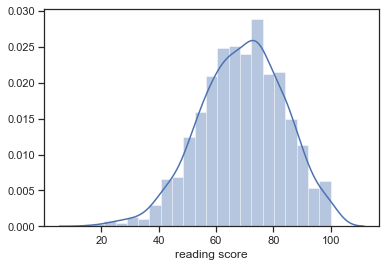

In [6]:
sns.distplot(data['reading score'])

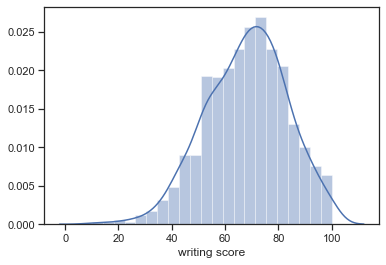

In [7]:
sns.distplot(data['writing score'])

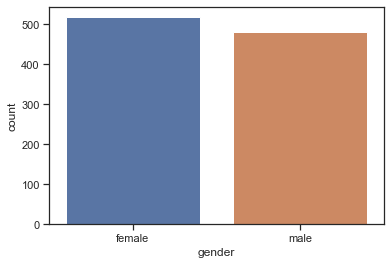

In [8]:
sns.countplot(data['gender'])

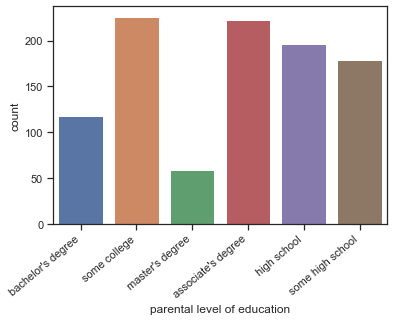

In [9]:
ax = sns.countplot(data['parental level of education'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

###### Задание 1.

In [10]:
gen_read = pd.crosstab(data['gender'], data['reading score'])
gen_read

reading score,17,23,24,26,28,29,31,32,34,37,...,90,91,92,93,94,95,96,97,99,100
gender,,,,,,,,,,,,,,,,,,,,,
female,1,0,1,0,0,1,1,1,2,0,...,12,5,9,5,3,8,1,4,3,14
male,0,1,1,1,1,1,1,0,2,3,...,5,1,1,1,0,0,3,1,0,3


Слишком много столбцов, объединяем.

Таблица сопряженности:

In [11]:
gen_readq = pd.crosstab(data['gender'], pd.qcut(data['reading score'], 3))
gen_readq

reading score,"(16.999, 63.0]","(63.0, 76.0]","(76.0, 100.0]"
gender,,,
female,130,181,207
male,211,159,112


Совместное распределение параметров

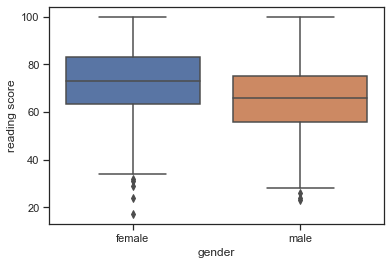

In [12]:
sns.boxplot(data['gender'], data['reading score'])

In [13]:
chi, p_value, c = chi2(gen_readq)
print(f'Статистика = {chi}')
print(f'p_value = {p_value}')
print(f'Мера крамера = {c}')

Статистика = 47.721381580660974
p_value = 4.3394399185103794e-11
Мера крамера = 0.21845224096049226


p_value < 0.05 $\Rightarrow$ отвергаем гипотезу $H_0$ в пользу гипотезы $H_1$: параметры gender и reading score зависимы

Мера крамера c < 0.3 $\Rightarrow$ слабая

###### Задание 2.

In [14]:
edu_write = pd.crosstab(data['parental level of education'], data['writing score'])
edu_write

writing score,10,15,19,22,23,27,28,30,32,33,...,91,92,93,94,95,96,97,98,99,100
parental level of education,,,,,,,,,,,,,,,,,,,,,
associate's degree,0,0,0,0,0,0,0,0,0,0,...,2,4,3,2,5,0,0,1,1,1
bachelor's degree,0,0,0,0,0,0,0,0,0,0,...,1,2,1,0,2,1,0,0,1,7
high school,0,1,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
master's degree,0,0,0,0,0,0,0,0,0,0,...,2,0,1,1,1,1,0,0,0,4
some college,0,0,1,0,0,1,0,0,1,2,...,6,2,2,3,0,1,1,1,2,0
some high school,1,0,0,1,0,1,1,0,1,0,...,0,1,1,0,0,1,1,0,0,1


Слишком много столбцов, объединяем.

Таблица сопряженности:

In [15]:
edu_writeq = pd.crosstab(data['parental level of education'], pd.qcut(data['writing score'], 3))
edu_writeq

writing score,"(9.999, 62.0]","(62.0, 75.0]","(75.0, 100.0]"
parental level of education,,,
associate's degree,67,73,82
bachelor's degree,30,37,51
high school,89,73,34
master's degree,10,23,26
some college,74,72,80
some high school,79,45,55


Совместное распределение параметров

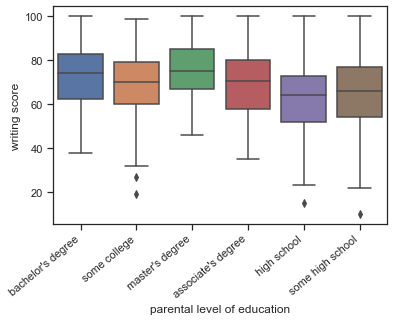

In [16]:
ax = sns.boxplot(data['parental level of education'], data['writing score'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

In [17]:
chi, p_value, c = chi2(edu_writeq)
print(f'Статистика = {chi}')
print(f'p_value = {p_value}')
print(f'Мера крамера = {c}')

Статистика = 48.30495692975623
p_value = 5.459452674383414e-07
Мера крамера = 0.15541067680464593


p_value < 0.05 $\Rightarrow$ отвергаем гипотезу $H_0$ в пользу гипотезы $H_1$: параметры parental level of education и writing score зависимы

Мера крамера c < 0.3 $\Rightarrow$ слабая

###### Задание 3.

In [18]:
read_write = pd.crosstab(data['reading score'], data['writing score'])
read_write

writing score,10,15,19,22,23,27,28,30,32,33,...,91,92,93,94,95,96,97,98,99,100
reading score,,,,,,,,,,,,,,,,,,,,,
17,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,0,0,0,0,0,...,0,2,1,2,0,0,0,0,0,1
96,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,1,0
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,3,0,0,1,0


Слишком много строк и столбцов, объединяем.

Таблица сопряженности:

In [19]:
edu_writeq = pd.crosstab(pd.qcut(data['reading score'], 3), pd.qcut(data['writing score'], 3))
edu_writeq

writing score,"(9.999, 62.0]","(62.0, 75.0]","(75.0, 100.0]"
reading score,,,
"(16.999, 63.0]",305,36,0
"(63.0, 76.0]",44,245,51
"(76.0, 100.0]",0,42,277


Совместное распределение параметров

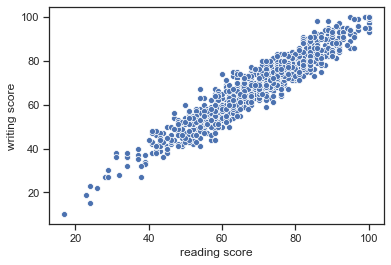

In [20]:
sns.scatterplot(data['reading score'], data['writing score'])

In [21]:
chi, p_value, c = chi2(edu_writeq)
print(f'Статистика = {chi}')
print(f'p_value = {p_value}')
print(f'Мера крамера = {c}')

Статистика = 1130.0875684543005
p_value = 0.0
Мера крамера = 0.7516939431890817


p_value < 0.05 $\Rightarrow$ отвергаем гипотезу $H_0$ в пользу гипотезы $H_1$: параметры reading score и writing score зависимы

Мера крамера c > 0.7 $\Rightarrow$ сильная